In [143]:
import numpy as np
import pandas as pd
import scanpy as sc

In [144]:
sc.settings.verbosity = 2             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_versions()
sc.settings.set_figure_params(dpi=80)

scanpy==1.4.5.post3 anndata==0.7.1 umap==0.3.10 numpy==1.17.2 scipy==1.3.1 pandas==0.25.1 scikit-learn==0.21.3 statsmodels==0.10.1


In [145]:
from process_raw_data import *

### Set up processing parameters

In [146]:
cellBCpath = '/wynton/scratch/bp205/barcodes/MDA_barcode_identities.csv'
geneBCpath = '/wynton/scratch/bp205/barcodes/sample_barcodes/MDA_genetic_barcodes.txt'
matrixPath = '/wynton/scratch/bp205/raw/MDA_BW/filtered_feature_bc_matrix'

outfilePathFiltNorm = '/wynton/scratch/bp205/processed/MDA_filtered_normalized_adata.h5ad'
outfilePathFiltNorm_loom = '/wynton/scratch/bp205/processed/MDA_filtered_normalized_adata.loom'
outfilePathFiltNorm_R = '/wynton/scratch/bp205/processed/MDA_filtered_normalized_adata_R/'
outfilePathFiltNorm_csv = '/wynton/scratch/bp205/processed/MDA_filtered_normalized_adata_R/MDA_filtered_normalized_adata.csv'

outfilePathFilt = '/wynton/scratch/bp205/processed/MDA_filtered_adata.h5ad'
outfilePathFilt_loom = '/wynton/scratch/bp205/processed/MDA_filtered_adata.loom'
outfilePathFilt_R = '/wynton/scratch/bp205/processed/MDA_filtered_adata_R/'
outfilePathFilt_csv = '/wynton/scratch/bp205/processed/MDA_normalized_adata_R/MDA_filtered_adata.csv'

outfilePathNorm = '/wynton/scratch/bp205/processed/MDA_normalized_adata.h5ad'
outfilePathNorm_loom = '/wynton/scratch/bp205/processed/MDA_normalized_adata.loom'
outfilePathNorm_R = '/wynton/scratch/bp205/processed/MDA_normalized_adata_R/'
outfilePathNorm_csv = '/wynton/scratch/bp205/processed/MDA_normalized_adata_R/MDA_normalized_adata.csv'

outfilePath = '/wynton/scratch/bp205/processed/MDA_adata.h5ad'
outfilePath_loom = '/wynton/scratch/bp205/processed/MDA_adata.loom'
outfilePath_R = '/wynton/scratch/bp205/processed/MDA_adata_R/'
outfilePath_csv = '/wynton/scratch/bp205/processed/MDA_adata_R/MDA_adata.csv'


minN_genes = 200
minN_cells = 3
maxN_genes = 7000
maxMito_percent = 0.1

### Load Cell barcodes and Sample barcodes

In [147]:
cellBC = pd.read_csv(cellBCpath, usecols=[1,2,3])
cellBC = cellBC[cellBC['multiseq barcode']!='DOUBLET']

geneBC = pd.read_csv(geneBCpath, sep='\t', index_col=0)
BCmap = create_barcode_map(cellBC, geneBC)

In [148]:
np.unique(cellBC.loc[:,'multiseq barcode'])

array(['ACCATCGAAGAACCCGTT', 'AGTACGCTGACCACGACA', 'ATCCCGCTACTCCGAACC',
       'CACAGAACAAATCGACAA', 'CCTGATTTTAGCGTCACC', 'CTAGTCACCGCACTTTTA',
       'GAGTCAGGCTGGTGATCG', 'TGGTAACCGAGGACGACG'], dtype=object)

### Loading raw sample x gene counts matrix

In [149]:
adata = read_matrix(matrixPath)

... reading from cache file cache/wynton-scratch-bp205-raw-MDA_BW-filtered_feature_bc_matrix-matrix.h5ad


In [150]:
adata = add_cell_type_to_obs(adata, BCmap)

In [151]:
adata.shape

(19384, 33694)

### Visalizing the highest expression genes 

normalizing counts per cell
    finished (0:00:01)


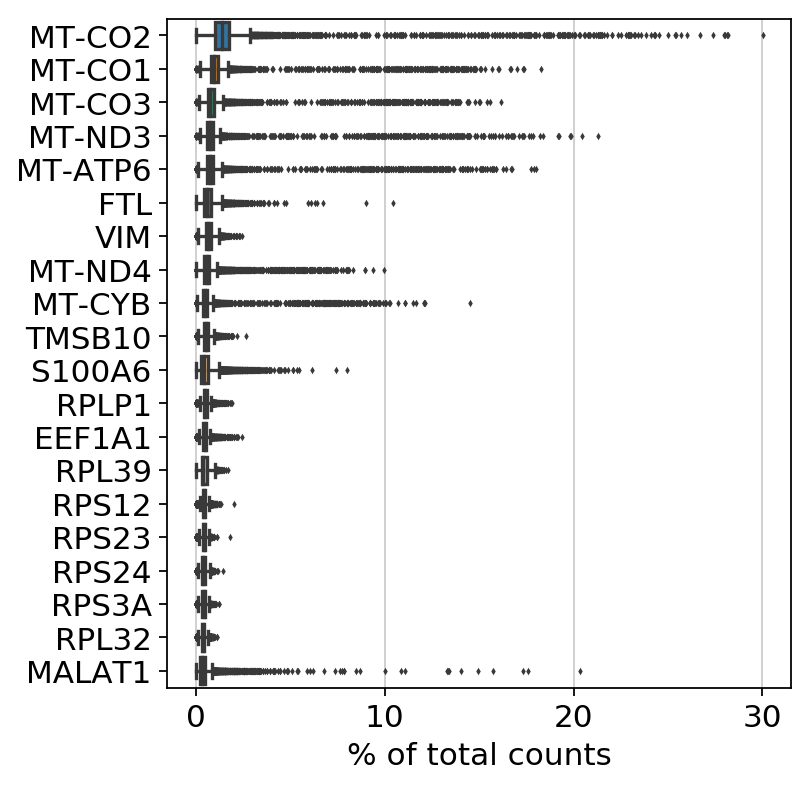

In [152]:
sc.pl.highest_expr_genes(adata, n_top=20, )

Remove cells with fewer gene counts than a detection threshold, and are found in fewer than $n$ cells

In [153]:
adata = filter_minGenes_minCells(adata, minN_genes, minN_cells)

filtered out 97 cells that have less than 200 genes expressed
filtered out 12074 genes that are detected in less than 3 cells


In [154]:
adata.shape

(19287, 21620)

Remove all cells which are not mapped to a specific sample (due to degenerate MULTI or genetic barcodes)

In [155]:
adata = keep_real_cells(adata)

In [156]:
adata.shape

(7284, 21620)

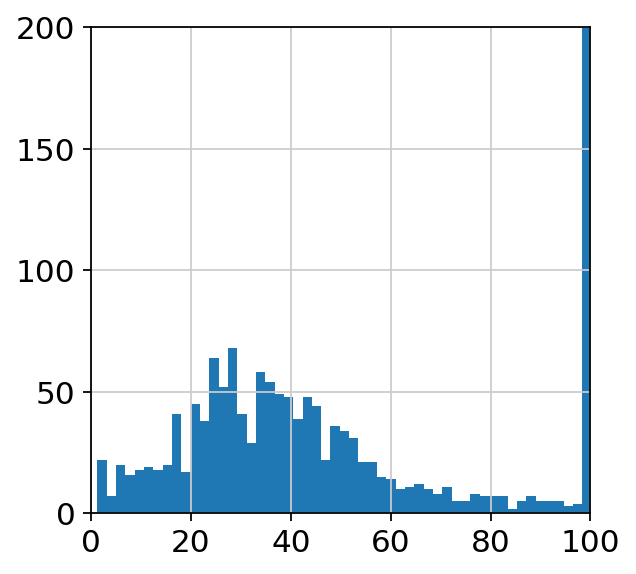

In [157]:
from matplotlib import pyplot as plt
vals = adata.obs.quality.values.copy()
vals[np.isinf(vals)] = 100
plt.hist(vals,bins=100)
plt.xlim(0,100)
plt.ylim(0,200)
plt.show()

### Determining % mitochondria-associated genes 

Trying to set attribute `.obs` of view, copying.
... storing 'SampleType' as categorical
... storing 'feature_types' as categorical


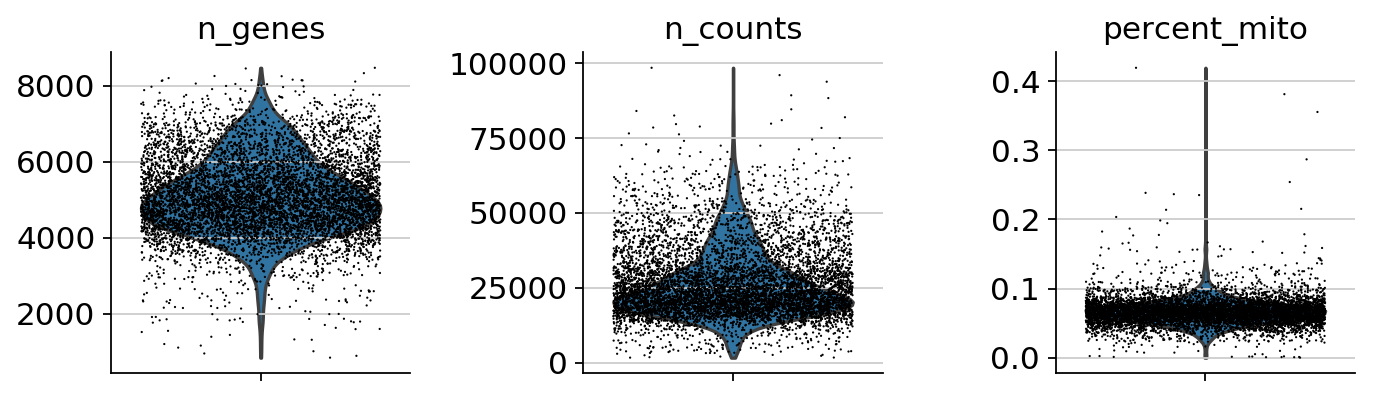

In [158]:
adata = calc_percentMito_nCounts(adata)
sc.pl.violin(adata, ['n_genes', 'n_counts', 'percent_mito'],
             jitter=0.4, multi_panel=True)

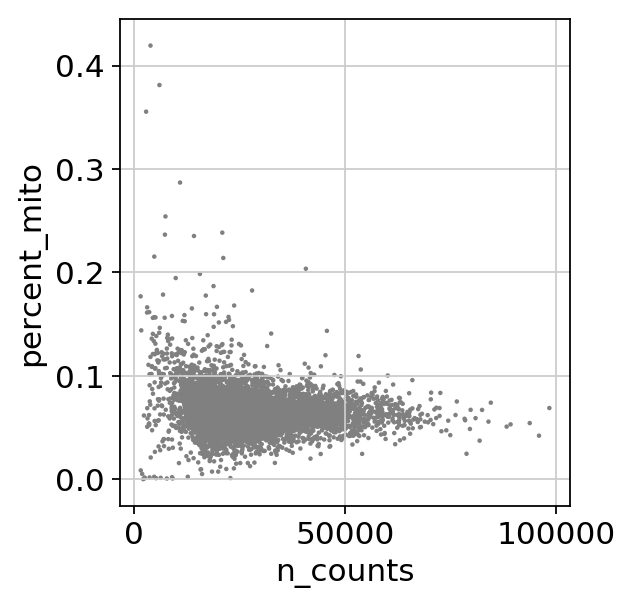

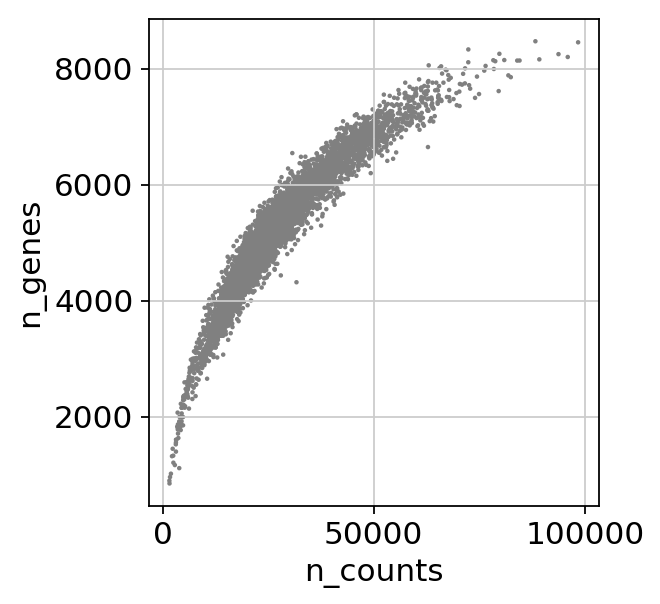

In [159]:
sc.pl.scatter(adata, x='n_counts', y='percent_mito')
sc.pl.scatter(adata, x='n_counts', y='n_genes')

### Filtering out cells with high gene counts, and high mitochondrial percentage

In [160]:
adata = filter_genes_mito(adata, maxN_genes, maxMito_percent)

In [161]:
adata.shape

(6746, 21620)

### Normalize count matrix (Total Normalization) and log-transform the count values

In [162]:
adata, backup = normalize_and_log(adata)

normalizing counts per cell
    finished (0:00:18)


/wynton/home/students/snanda/anaconda3/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:298: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(data)


In [163]:
## Save an unnormalized, unprocessed version of the file
backup.write(outfilePath)
backup.write_loom(outfilePath_loom)
backup.write_csvs(outfilePath_R)
np.savetxt(outfilePath_csv,backup.X.todense(),delimiter=',')

writing .csv files to /wynton/scratch/bp205/processed/MDA_adata_R


In [164]:
## Save a processed version of the file
adata.write(outfilePathNorm)
adata.write_loom(outfilePathNorm_loom)x
adata.write_csvs(outfilePathNorm_R)
np.savetxt(outfilePathNorm_csv,adata.X.todense(),delimiter=',')

writing .csv files to /wynton/scratch/bp205/processed/MDA_normalized_adata_R


### Plot highly variable genes 

extracting highly variable genes


/wynton/home/students/snanda/anaconda3/lib/python3.7/site-packages/scanpy/preprocessing/_highly_variable_genes.py:58: RuntimeWarning: invalid value encountered in log
  dispersion = np.log(dispersion)


    finished (0:00:02)


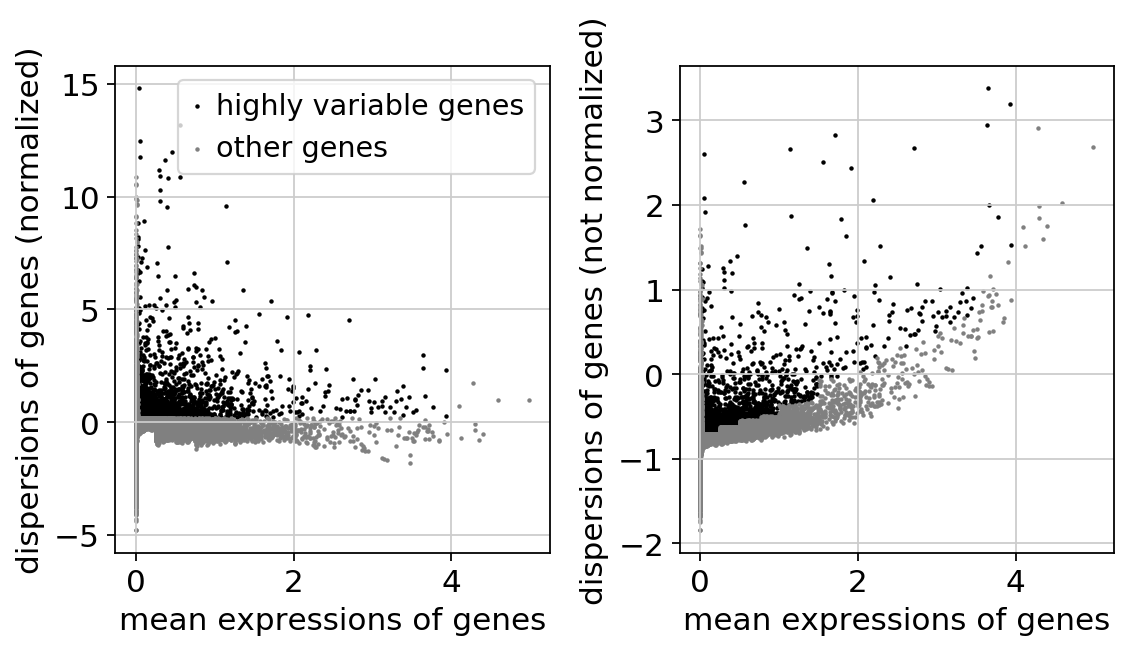

In [165]:
sc.pp.highly_variable_genes(adata, min_mean=0.02, max_mean=4, min_disp=0.2)
sc.pl.highly_variable_genes(adata)

### Keep only genes which are 'highly variable'

In [166]:
backup_filtered = backup.copy()[:,adata.var.highly_variable]
backup_filtered.write(outfilePathFilt)
backup_filtered.write_loom(outfilePathFilt_loom)
backup_filtered.write_csvs(outfilePathFilt_R)
np.savetxt(outfilePathFilt_csv,backup_filtered.X.todense(),delimiter=',')

writing .csv files to /wynton/scratch/bp205/processed/MDA_filtered_adata_R


In [167]:
adata = adata[:, adata.var.highly_variable]

### Regress out the mitochondrial fraction and total counts, rescale the data, and perform PCA

In [168]:
adata = regress_scale_pca(adata)

regressing out ['n_counts', 'percent_mito']
    sparse input is densified and may lead to high memory use
    finished (0:00:22)
computing PCA with n_comps = 50
    on highly variable genes
    finished (0:00:03)


In [169]:
## Save a processed version of the file
adata.write(outfilePathFiltNorm)
adata.write_loom(outfilePathFiltNorm_loom)
adata.write_csvs(outfilePathFiltNorm_R)
np.savetxt(outfilePathFiltNorm_csv,adata.X,delimiter=',')

The loom file will lack these fields:
{'PCs', 'X_pca'}
Use write_obsm_varm=True to export multi-dimensional annotations
writing .csv files to /wynton/scratch/bp205/processed/MDA_filtered_normalized_adata_R
